# ARIMA / Autoregression

In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [160]:
df = pd.read_csv('../data/cryptocurrencypricehistory/coin_Bitcoin.csv')
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.set_index(pd.DatetimeIndex(df['Date'])).drop('Date', axis=1).drop('SNo', axis=1)
df.head()

Name Symbol        High         Low        Open       Close  \
Date                                                                         
2013-04-29  Bitcoin    BTC  147.488007  134.000000  134.444000  144.539993   
2013-04-30  Bitcoin    BTC  146.929993  134.050003  144.000000  139.000000   
2013-05-01  Bitcoin    BTC  139.889999  107.720001  139.000000  116.989998   
2013-05-02  Bitcoin    BTC  125.599998   92.281898  116.379997  105.209999   
2013-05-03  Bitcoin    BTC  108.127998   79.099998  106.250000   97.750000   

            Volume     Marketcap  
Date                              
2013-04-29     0.0  1.603769e+09  
2013-04-30     0.0  1.542813e+09  
2013-05-01     0.0  1.298955e+09  
2013-05-02     0.0  1.168517e+09  
2013-05-03     0.0  1.085995e+09

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

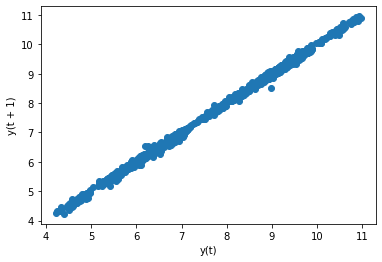

In [161]:
pd.plotting.lag_plot(np.log(df['Close']))

The correlation in the lag plot (lag 1) suggests that an autoregressive model is appropriate.

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

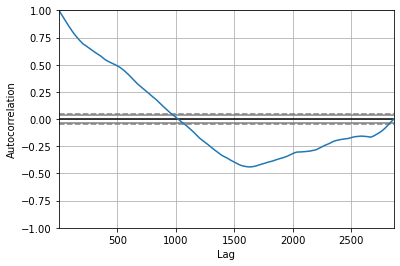

In [162]:
pd.plotting.autocorrelation_plot(np.log(df['Close']))

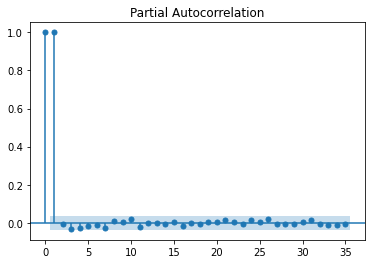

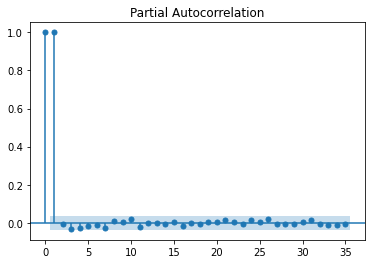

In [266]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df['Close'].apply(np.log))

## Check Stationarity

In [163]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(df['Close'].apply(np.log).values)
print('ADF-Statistic:',adf_test[0])
print('p-value:',adf_test[1])
print('Critical Values', adf_test[4])

ADF-Statistic: -0.464549858472957
p-value: 0.8987506859614918
Critical Values {'1%': -3.4326562806874334, '5%': -2.8625589559080318, '10%': -2.567312420641838}


This suggests that the close price of ADA is not stationary. Perhaps the model should be differenced.

<AxesSubplot:xlabel='Date'>

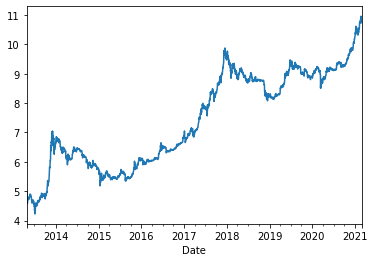

In [164]:
df['Close'].apply(np.log).plot()

<AxesSubplot:xlabel='Date'>

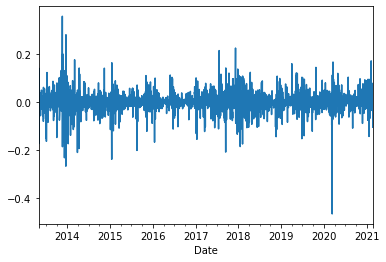

In [284]:
#pandas series.diff()
df['Close'].apply(np.log).diff().fillna(0).plot()

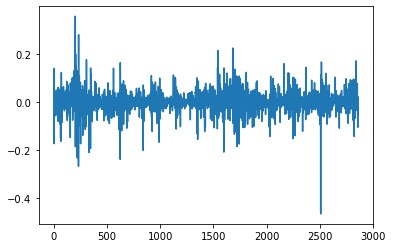

In [290]:
#numpy numpy.diff()
plt.plot(np.diff(df['Close'].apply(np.log).fillna(0)))

In [281]:
adf_test = adfuller(np.diff(df['Close'].apply(np.log).fillna(0).values))
print('ADF-Statistic:',adf_test[0])
print('p-value:',adf_test[1])
print('Critical Values', adf_test[4])

ADF-Statistic: -10.105020721622926
p-value: 1.0353835063413519e-17
Critical Values {'1%': -3.4326562806874334, '5%': -2.8625589559080318, '10%': -2.567312420641838}


Now the ADF test results show that the data is now stationary. However, this manual differencing may not need to be done if an ARIMA model is used.

## Scaling instead of ln?

In [409]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop('Volume', axis=1).iloc[:,2:].diff().dropna().values)

## Autoregression

In [505]:
#X = df.drop('Close', axis=1).iloc[:,2:].apply(np.log).values
from statsmodels.tsa.ar_model import AutoReg
X = df['Close'].apply(np.log).diff().dropna().values
forecast = 30
X_train, X_test = X[len(X)-2*forecast:len(X)-forecast], X[len(X)-forecast:]

In [502]:
autoreg = AutoReg(X_train, lags=2)
autoreg_fit = autoreg.fit()
print('Coefficients:{}'.format(autoreg_fit.params))

Coefficients:[ 0.00545343  0.03200261 -0.06450293]


C:\Users\Michael\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [503]:
X_hat = autoreg_fit.forecast(forecast)
print(X_hat)

[ 0.01287242 -0.0002637   0.00461468  0.00561812  0.00533557  0.0052618
  0.00527766  0.00528293  0.00528208  0.00528171  0.00528175  0.00528178
  0.00528177  0.00528177  0.00528177  0.00528177  0.00528177  0.00528177
  0.00528177  0.00528177  0.00528177  0.00528177  0.00528177  0.00528177
  0.00528177  0.00528177  0.00528177  0.00528177  0.00528177  0.00528177]


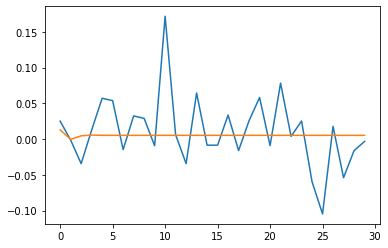

In [504]:
plt.plot(X_test)
plt.plot(X_hat)

## Vector Autoregression

In [341]:
from statsmodels.tsa.vector_ar.var_model import VAR

In [489]:
X = df.drop('Volume', axis=1).iloc[:,2:].apply(np.log).values
forecast = 30
X_train, X_test = X[len(X)-4*forecast:len(X)-forecast], X[len(X)-forecast:]

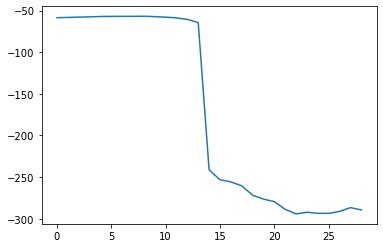

In [490]:
varmod = VAR(X_train)
lags = range(1,30)
plt.plot([varmod.fit(p).aic for p in lags])

In [491]:
varmod_fit = varmod.fit(21)

In [492]:
X_hat = varmod_fit.forecast(X_train, steps=30)
X_hat

array([[10.24952226, 10.14651957, 10.42028441, 10.07759634, 26.81686105],
       [ 9.84379441,  9.97635176, 10.07496325,  9.80809132, 26.54734644],
       [10.20990103, 10.22986938,  9.80531779, 10.38885711, 27.12810174],
       [10.45485946, 10.46118668, 10.39027147, 10.4291629 , 27.16823564],
       [ 9.91648988, 10.42627103, 10.42854787,  9.80518288, 26.54424788],
       [ 9.76764027,  9.90533921,  9.80492114,  9.81239493, 26.55133726],
       [ 9.84860632, 10.13464111,  9.81334287,  9.88152753, 26.62031911],
       [ 9.94311558, 10.00796536,  9.88154187,  9.90788335, 26.64662205],
       [10.12612112, 10.28637151,  9.91097203, 10.40906208, 27.14769206],
       [10.24495505, 10.66762479, 10.41235157, 10.27551401, 27.01377704],
       [ 9.77624403, 10.49440762, 10.27533963,  9.72411142, 26.46226628],
       [10.36839442, 10.76658871,  9.72411939, 10.76979176, 27.50782223],
       [11.51711534, 11.68628422, 10.7745809 , 12.04827452, 28.78608558],
       [11.62408201, 12.22784376, 12.0

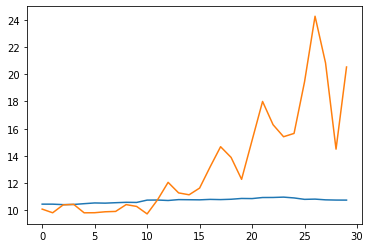

In [493]:
plt.plot(X_test[:,3])
plt.plot(X_hat[:,3])

## Autoregressive Integrated Moving Average (ARIMA)

In [325]:
from statsmodels.tsa.arima.model import ARIMA
#X = df.drop('Close', axis=1).iloc[:,2:].apply(np.log).values
X = df['Close'].apply(np.log).values
forecast = 30
X_train, X_test = X[0:len(X)-forecast], X[len(X)-forecast:]

In [326]:
arima_mod = ARIMA(X_train, order=(1,1,0), dates=df.index.values, freq='D', trend='t')
arima_mod_fit = arima_mod.fit()

In [327]:
X_hat = arima_mod_fit.forecast(forecast)
X_hat

array([10.41903463, 10.42097238, 10.42289507, 10.42481795, 10.42674083,
       10.42866371, 10.43058659, 10.43250947, 10.43443235, 10.43635523,
       10.43827811, 10.44020098, 10.44212386, 10.44404674, 10.44596962,
       10.4478925 , 10.44981538, 10.45173826, 10.45366114, 10.45558402,
       10.4575069 , 10.45942978, 10.46135265, 10.46327553, 10.46519841,
       10.46712129, 10.46904417, 10.47096705, 10.47288993, 10.47481281])

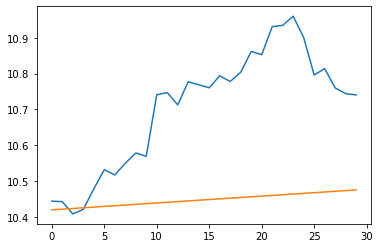

In [328]:
plt.plot(X_test)
plt.plot(X_hat)

## VARMA

In [93]:
from statsmodels.tsa.statespace.varmax import VARMAX
X = df.drop('Volume', axis=1).iloc[:,2:].apply(np.log).values
forecast = 30
X_train, X_test = X[1:len(X)-forecast], X[len(X)-forecast:]

In [106]:
varmod = VARMAX(X_train, order=(1,0), dates=df.index.values, freq='D')
varmod_fit = varmod.fit()
print('Coefficients:{}'.format(varmod_fit.params))

Coefficients:[ 4.69482753e-01 -1.32946380e+00 -1.37362347e-02 -4.29953005e-01
 -4.18956026e-01  2.35292702e-01 -2.70870723e-01 -8.82711963e-03
  1.07549440e+00 -2.87916443e-02 -4.14247638e-01  1.76627716e-01
  5.52963308e-02  1.09213976e+00  8.28010112e-02  1.19023701e-02
  2.95018941e-03 -7.15587758e-03  9.91430795e-01  7.57994016e-04
 -2.91232196e-02 -1.25493415e-01  7.18405576e-02  1.05354395e+00
  2.68630451e-02 -2.89938272e-02 -1.25458016e-01  7.17694979e-02
  5.41072925e-02  1.02620109e+00  2.80713685e-02  1.25394681e-02
  3.31881673e-02  4.12448538e-04  1.19470098e-04  3.19330361e-03
  3.15233051e-02  2.32821374e-02 -1.68964065e-03  1.63096869e-02
  3.15338749e-02  2.32843965e-02 -1.58352716e-03  1.63042338e-02
  1.65791188e-04]


In [107]:
X_hat = varmod_fit.predict()
X_hat

0          1          2          3          4
2013-04-29   7.416186   7.367394   7.392269   7.394102  23.955642
2013-04-30   4.970789   4.884377   4.932770   4.934087  21.156724
2013-05-01   4.838336   4.661623   4.760754   4.774184  20.997164
2013-05-02   4.745355   4.544445   4.654985   4.669319  20.892609
2013-05-03   4.675677   4.487848   4.580429   4.607031  20.830616
...               ...        ...        ...        ...        ...
2021-02-23  10.424928  10.355918  10.393803  10.394713  27.130567
2021-02-24  10.423852  10.354833  10.392723  10.393633  27.129358
2021-02-25  10.422775  10.353748  10.391644  10.392553  27.128148
2021-02-26  10.421699  10.352663  10.390564  10.391472  27.126938
2021-02-27  10.420621  10.351577  10.389483  10.390391  27.125728

[2862 rows x 5 columns]

<AxesSubplot:>

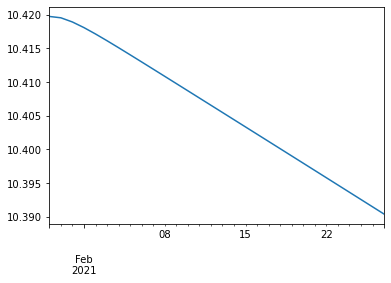

In [115]:
X_hat[3][-30:].plot()

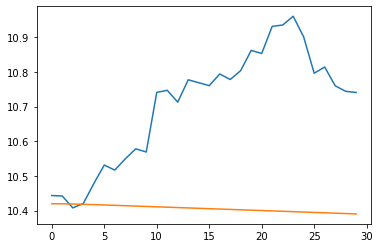

In [118]:
plt.plot(X_test[:,3])
plt.plot(X_hat[3][-30:].values)